## Sandbox for getting article pair similarity after filtering by named entities 

In [36]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from tqdm import tqdm 
import networkx as nx
import pickle

In [37]:
#NOTE: very important, which entity categories to keep 
#article showing all entity types below
# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
TO_KEEP = ["org","event", "person", "work_of_art", "product"]
CLUSTER_CUTOFF = [2, 1000]
#for testing 
OUT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/embeddingClusterDf_2_1000_83.tsv"
SIM_THRESH = .83
INVERTED_ENT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/invertedEntityIndex.pkl"
EMBEDS_PATH = "/shared/3/projects/newsDiffusion/data/processed/articleEmbeddings/embeddings.pkl"

In [38]:
#this is the df with our inverted index in it
invertedDf = pd.read_pickle(INVERTED_ENT_PATH)

In [39]:
print(f"len before filtering: {len(invertedDf)}")
invertedDf = invertedDf[(invertedDf["numArticles"] >= CLUSTER_CUTOFF[0]) & (invertedDf["numArticles"] <= CLUSTER_CUTOFF[1])]
print(f"len after filtering: {len(invertedDf)}")

len before filtering: 7436473
len after filtering: 2608726


In [40]:
#a dictionary so we can get the embeddings we need quickly 
#embeddingsDict = embeddingsDf.set_index("key").to_dict(orient="index")
embedsFile = open(EMBEDS_PATH, "rb")
embeddingsDict = pickle.load(embedsFile)

In [41]:
#get a list of the keys that correspond to each named entity 
#sort so that smaller clusters will be processed first :) 
keyOptions = list(invertedDf.sort_values("numArticles", ascending=False)["key"])

In [42]:
#sanity check, all of the embeddings are the proper length 
i = 0 
for key, val in embeddingsDict.items(): 
    if len(val["embedding"]) < 768: 
        print("broken") 

In [43]:
invertedDf.head()

,ent_type,entity,key,numArticles
2,event,arab,"[4933735, 4933736]",2
19,event,2005,"[410138, 455564, 462313, 466929]",4
22,event,27th,"[1176150, 1190340]",2
31,event,85,"[3530128, 4307053]",2
33,event,94,"[1893807, 1953515]",2


In [44]:
from sklearn.metrics.pairwise import cosine_similarity
entGroup = keyOptions[0]
myMat = np.matrix([embeddingsDict[key]["embedding"] for key in entGroup])

In [45]:
pairSims = cosine_similarity(myMat)

In [46]:
#a dictionary of pairs we've considered 
#compared = {i:{} for i in range(0, 6000000)}

outDict = {}
outList = []

#for each list of article keys associated with entities 
for i, entGroup in enumerate(tqdm(keyOptions)): 
    
    #within each list of article keys, consider the unique pairs 
    #and get their cosine similarities 
    #for i in range(0, len(entGroup)): 
    myMat = np.matrix([embeddingsDict[key]["embedding"] for key in entGroup])
    pairSims = cosine_similarity(myMat)
    
    for i, lKey in enumerate(entGroup):
        for j, rKey in enumerate(entGroup):
            sim = pairSims[i,j]
            if sim >= .6: 
                outDict[(lKey, rKey)] = sim
            


100%|██████████| 2608726/2608726 [52:20<00:00, 830.76it/s] 


In [48]:
compared = outDict

In [49]:
#turn our dictionary of article similarities into a dataframe for easier manipulation if need be 
pairsDf = pd.DataFrame.from_dict(compared, orient="index").reset_index()

In [50]:
pairsDf[["key1", "key2"]] = pairsDf["index"].tolist()

In [51]:
pairsDf = pairsDf.drop(columns="index")

In [52]:
pairsDf = pairsDf.rename(columns={0:"simScore"})

(array([64262374., 48747868., 36325320., 26474026., 18715388., 12753722.,
         8084318.,  4503328.,  2543734.,  6249132.]),
 array([0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 10 artists>)

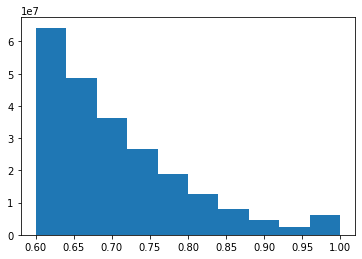

In [53]:
plt.hist(pairsDf["simScore"])

In [70]:
overThresh = pairsDf[pairsDf["simScore"] >= SIM_THRESH]

In [55]:
graph = nx.from_pandas_edgelist(overThresh[["key1", "key2"]], "key1", "key2")

components = nx.connected_components(graph)
compList = [comp for comp in components]

In [61]:
len(compList)

2123624

In [62]:
len(overThresh)

24094126

In [59]:
clusters = pd.DataFrame({"cluster":compList}) #.reset_index()

#we can remove clusters of size one 
clusters["clustSize"] = clusters["cluster"].apply(lambda x: len(list(x)))

clusters = clusters[clusters["clustSize"] > 1]

clusters["clustNum"] = list(range(0, len(clusters)))

In [65]:
clustDf = clusters.explode("cluster").rename(columns={"index":"clustNum", "cluster":"key"})

In [66]:
clustSizes = pd.DataFrame(clustDf["clustNum"].value_counts()).reset_index()

clustSizes.value_counts()

(0.0, 5000.0)

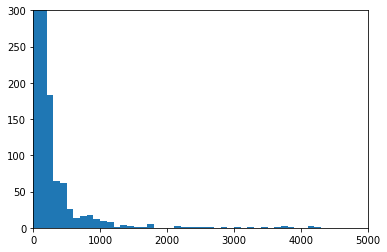

In [68]:
plt.hist(clustSizes["count"], bins=np.arange(0, 5000, 100))
plt.ylim(0, 300)
plt.xlim(0, 5000)

In [112]:
clustDf.head()

,key,clustSize,clustNum
0,814,2,0
0,2631,2,0
1,68890,3,1
1,70380,3,1
1,75348,3,1


In [71]:
clustDf.to_csv(OUT_PATH, sep="\t")